In [49]:
import seaborn as sns

def boxplot_histogram(x, bins=None, figsize=(15,10)):
    """Creates two plots stacked underneath each other. Upper plot: Boxplot. Lower plot: Histogram. Input is any array."""
    sns.set(style="ticks")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},
                                        figsize=figsize)

    sns.boxplot(x, notch=True,ax=ax_box)
    sns.distplot(x, ax=ax_hist,bins=bins)
    ax_hist.grid(True)
    ax_hist.set_title('Historgram')
    ax_hist.set_ylabel('Percentage')
    ax_hist.set_xlabel('Value Range')

    ax_box.set(yticks=[])
    ax_box.set_title('Boxplot')
    ax_box.grid(True)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
    plt.show()
    

# Load Modules


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline
import sklearn
import seaborn as sns

# Datenaufbereitung

## Libraries & Settings

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [3]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import qgrid
from datetime import datetime as dtt

from pa_lib.file import data_files, load_bin, store_bin, load_csv, write_xlsx, load_xlsx
from pa_lib.data import (
    calc_col_partitioned,
    clean_up_categoricals,
    unfactorize,
    flatten,
    replace_col,
    cond_col,
    desc_col,
    unfactorize,
    as_dtype,
    flatten_multi_index_cols,
)
from pa_lib.util import obj_size, cap_words, normalize_rows, clear_row_max
from pa_lib.log import time_log, info
from pa_lib.vis import dive

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)


def qshow(df, fit_width=False):
    return qgrid.show_grid(
        df, grid_options={"forceFitColumns": fit_width, "fullWidthRows": False}
    )

## Load data

In [4]:
%%time
bd_raw = load_bin("bd_data.feather").rename(
    mapper=lambda name: cap_words(name, sep="_"), axis="columns"
)
bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)

2019-09-12 09:51:29 [INFO] Reading from file C:\Users\stc\data\bd_data.feather
2019-09-12 09:51:29 [INFO] Finished loading binary file in 0.18s (0.77s CPU)


Wall time: 1.54 s


In [5]:
desc_col(bd)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,category,0/675378,32244
Endkunde,category,0/675378,30312
EK_Abc,category,1154/674224,8
EK_Boni,category,76/675302,3
EK_Plz,category,164/675214,2975
EK_Ort,category,164/675214,3023
EK_Land,category,164/675214,46
EK_HB_Apg_Kurzz,category,27734/647644,89
EK_Aktiv,category,0/675378,2
Agentur,category,322648/352730,3967


Kampagnen_Status:
- ``1 = In Bearbeitung``
- ``2 = Ausgeführt``
- ``3 = Annuliert``
- ``4 = Abgeschlossen``
- ``5 = In Rechnungskorrektur``

In [6]:
def last_notna(s):
    try:
        return s.loc[s.last_valid_index()]
    except KeyError:
        return np.NaN


def collect(s, sep=","):
    return sep.join(map(str, s[s.notna()].unique()))


# this takes around 90 seconds
with time_log("preparing EK_INFO"):
    ek_info = (
        bd.sort_values(["Endkunde_NR", "Kampagne_Erfassungsdatum"])
        .astype({"Endkunde_NR": "int64", "Kamp_Erfass_Jahr": "int16"})
        .groupby("Endkunde_NR")
        .agg(
            {
                "Endkunde": last_notna,
                "EK_Aktiv": last_notna,
                "EK_Land": last_notna,
                "EK_Plz": last_notna,
                "EK_Ort": last_notna,
                "Agentur": last_notna,
                "Endkunde_Branchengruppe": last_notna,
                "Endkunde_Branchengruppe_ID": last_notna,
                "Auftrag_Branchengruppe_ID": [collect, "nunique"],
                "Kamp_Erfass_Jahr": ["min", "max"],
                "Kampagne_Erfassungsdatum": ["min","max"] # max is kind of useless though, since it depends on the respective view date.
            }
        )
    )

ek_info.set_axis(
    labels="""Endkunde EK_Aktiv EK_Land EK_Plz EK_Ort Agentur EK_BG EK_BG_ID Auftrag_BG_ID Auftrag_BG_Anz 
              Kamp_Erfass_Jahr_min Kamp_Erfass_Jahr_max Kampagne_Erfass_Datum_min Kampagne_Erfass_Datum_max""".split(),
    axis="columns",
    inplace=True,
)

ek_info = ek_info.reset_index()

2019-09-12 09:52:59 [INFO] Finished preparing EK_INFO in 81.73s (82.91s CPU)


In [7]:
ek_info.head(3)

,Endkunde_NR,Endkunde,EK_Aktiv,EK_Land,EK_Plz,EK_Ort,Agentur,EK_BG,EK_BG_ID,Auftrag_BG_ID,Auftrag_BG_Anz,Kamp_Erfass_Jahr_min,Kamp_Erfass_Jahr_max,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max
0,100034,Maurer + Salzmann AG,1,SCHWEIZ,8408,Winterthur,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,"720,405,400,295",4,2009,2018,2009-02-09,2018-10-31
1,100039,Bank BSU Genossenschaft,1,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Finanzwirtschaft,470,"470,720",2,2009,2019,2009-01-01,2019-09-01
2,100061,Mundwiler Juwelen AG,1,SCHWEIZ,8400,Winterthur,NaN,WG - Persönlicher Bedarf,555,555,1,2009,2009,2009-09-16,2009-09-16


## Booking Data (Beträge: Reservationen & Aushänge)

In [74]:
def sum_calc(df, col_year, col_week):
    return (
        df.loc[:, ["Endkunde_NR", col_year, col_week, "Netto"]]
        .pipe(unfactorize)
        .groupby(["Endkunde_NR", col_year, col_week], observed=True, as_index=False)
        .agg({"Netto": ["sum"]})
        .set_axis(
            f"Endkunde_NR {col_year} {col_week} Netto_Sum".split(),
            axis="columns",
            inplace=False,
        )
    )


def aggregate_bookings(df, period):
    info(f"Period: {period}")
    info("Calculate Reservation...")
    df_res = sum_calc(df, "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}")
    info("Calculate Aushang...")
    df_aus = sum_calc(df, "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}")

    info("Merge Results...")
    df_aggr = df_res.merge(
        right=df_aus,
        left_on=["Endkunde_NR", "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}"],
        right_on=["Endkunde_NR", "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"],
        how="outer",
        suffixes=("_Res", "_Aus"),
    ).rename(
        {"Kamp_Erfass_Jahr": "Jahr", f"Kamp_Erfass_{period}": period}, axis="columns"
    )

    df_aggr = (
        df_aggr.fillna(
            {
                "Jahr": df_aggr.Kamp_Beginn_Jahr,
                period: df_aggr[f"Kamp_Beginn_{period}"],
                "Netto_Sum_Res": 0,
                "Netto_Sum_Aus": 0,
            }
        )
        .drop(["Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"], axis="columns")
        .astype({"Jahr": "int16"})
        .astype({period: "int8"})
        .sort_values(["Jahr", "Endkunde_NR", period])
        .reset_index(drop=True)
    )
    
    # Needed for data preparation
    df_aggr.eval("YYYYKW_2 = Jahr * 100 + KW_2", inplace=True)
    
    return df_aggr

In [24]:
bd_aggr_2w = aggregate_bookings(bd, 'KW_2')

2019-09-12 10:05:48 [INFO] Period: KW_2
2019-09-12 10:05:48 [INFO] Calculate Reservation...
2019-09-12 10:05:49 [INFO] Calculate Aushang...
2019-09-12 10:05:49 [INFO] Merge Results...


In [25]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus,YYYYKW_2
0,103092,2007,45,5310.0,0.0,200745
1,114140,2007,23,50000.0,0.0,200723
2,116266,2007,23,5700.0,0.0,200723
3,142915,2007,13,50000.0,0.0,200713
4,165220,2007,23,587.0,0.0,200723
5,177225,2007,45,2365.0,0.0,200745
6,469638,2007,51,1071.0,0.0,200751
7,494570,2007,45,5250.0,0.0,200745
8,494878,2007,47,5900.0,0.0,200747
9,100098,2008,39,16755.0,0.0,200839


## Global Variables: 

In [244]:
import datetime as dt
from dateutil.relativedelta import relativedelta

date_now      = dt.datetime.now()
date_training = date_now - relativedelta(years=1) 
number_years  = 4 # how many years should be featured

current_year_kw_day = date_now.isocalendar()
current_yyyykw = current_year_kw_day[0]*100+current_year_kw_day[1] # Current calender week in format: YYYYKW

global_variables = dict({"date_now": date_now, 
                         "current_year_kw_day": current_year_kw_day,
                         "current_yyyykw"     : current_yyyykw,
                         "number_years"       : number_years,
                         "date_training"      : date_compare}
                       )
display(global_variables)

{'date_now': datetime.datetime(2019, 9, 12, 16, 47, 18, 84103),
 'current_year_kw_day': (2019, 37, 4),
 'current_yyyykw': 201937,
 'number_years': 4,
 'date_training': datetime.datetime(2018, 9, 12, 16, 46, 51, 381998)}

## Data Prep: Booking Data

In [64]:
def booking_yearly_totals(YYYYKW, year_span):
    """
    Computing yearly totals for Aushang and Reservation.
    Warning: Yearly totals do not necessarily align with calendar years!
    """
    #info("Starting: booking_yearly_totals")
    container_df = pd.DataFrame()
    container_df.loc[:,"Endkunde_NR"] =pd.Series(list(set(bd_aggr_2w.loc[:,"Endkunde_NR"])))
    #bd_aggr_2w.eval("YYYYKW_2 = Jahr * 100 + KW_2", inplace=True)
    info("Computing: Yearly total sums")
    for ry in list(range(year_span)):
        #bd_aggr_2w.loc[:,"YYYYKW_2"] = bd_aggr_2w.Jahr.map(lambda x: x*100) + bd_aggr_2w.KW_2
                
        bd_filtered = bd_aggr_2w.loc[((bd_aggr_2w.loc[:,"YYYYKW_2"] <  YYYYKW-100*ry) &
                                      (bd_aggr_2w.loc[:,"YYYYKW_2"] >= YYYYKW-100*(1+ry))),:].copy()
        
        bd_filtered.loc[:,"Year_Total"] = "_RY_"+str(ry)
        
        bd_pivot = bd_filtered.pivot_table(
            #index=["Endkunde_NR", "Jahr"],
            index=["Endkunde_NR"],
            #columns="KW_2",
            columns = ["Year_Total"],
            values=["Netto_Sum_Res","Netto_Sum_Aus"], # Cash amount of Resevation placed per in weeks of YYYYKW and YYYY(KW+1)
            aggfunc="sum",
            fill_value=0, # There's a difference between 0 and NaN. Consider 0 only when the customer has had a real booking or reservation prior.
        )
        
        # Flatten down dataframe:
        bd_flattened = pd.DataFrame(bd_pivot.to_records(index=False))
        
        # Re-add column with Endkunde_NR
        bd_flattened.loc[:,"Endkunde_NR"] = pd.Series(bd_pivot.index)
        
        # Renaming column names:
        bd_flattened.columns = [x.replace("', '",'')
                                .replace("', ",'')
                                .replace("('","")
                                .replace(")","")
                                .replace("'","") for x in bd_flattened.columns]
        
        # Left-Join to the container
        info("Merging: Left-Join to Container dataframe")
        container_df = pd.merge(container_df, bd_flattened, on="Endkunde_NR", how="left")
    
    # Replace all NaN with Zero
    container_df.fillna(0, inplace=True)
    
    return container_df
       

In [65]:
def booking_data(YYYYKW, year_span):
    """
    Creates pivot table for time span between YYYYKW and back the selected amount of years year_span
    """
    # Select the last four years based on new reference-column
    bd_filtered = bd_aggr_2w.loc[((bd_aggr_2w.loc[:,"YYYYKW_2"] <= YYYYKW) &
                                  (bd_aggr_2w.loc[:,"YYYYKW_2"] >=  YYYYKW-year_span*100)),:].copy()
    
    # Create new column containing names of the relative years: 
    #pd.options.mode.chained_assignment = None  # default='warn'
    max_Jahr = YYYYKW//100
    bd_filtered.loc[:,"Jahr_relative"] = "_RY_"+(max_Jahr-bd_filtered.loc[:,"Jahr"]).astype('str')+"_KW_"
    #pd.options.mode.chained_assignment = 'warn'  # default='warn'
    
    # Computing Sums for each KW and customer
    info("Computing: Pivot Table")
    bd_pivot    = bd_filtered.pivot_table(
        #index=["Endkunde_NR", "Jahr"],
        index=["Endkunde_NR"],
        #columns="KW_2",
        columns = ["Jahr_relative","KW_2"],
        values=["Netto_Sum_Res","Netto_Sum_Aus"] , # Cash amount of Resevation placed per in weeks of YYYYKW and YYYY(KW+1)
        aggfunc="sum",
        fill_value=0, # There's a difference between 0 and NaN. Consider 0 only when the customer has had a real booking or reservation prior.
    )
    # Flatten down dataframe
    bd_flattened = pd.DataFrame(bd_pivot.to_records(index=False))
    
    # Read column with Endkunde
    bd_flattened.loc[:,"Endkunde_NR"] = pd.Series(bd_pivot.index)
    
    # Renaming column names:
    bd_flattened.columns = [x.replace("', '",'')
                            .replace("', ",'')
                            .replace("('","")
                            .replace(")","") for x in bd_flattened.columns]
    
    # Label target variables:
    KW = "KW_"+str(int(YYYYKW- np.floor(YYYYKW/100)*100))
    bd_flattened.rename(columns={"Netto_Sum_Res_RY_0_"+KW: "Target_Sum_Res_RY_0_"+KW,
                                 "Netto_Sum_Aus_RY_0_"+KW: "Target_Sum_Aus_RY_0_"+KW},
                        inplace=True)
    bd_flattened.loc[:,"Target_Res_flg"] = bd_flattened.loc[:,"Target_Sum_Res_RY_0_"+KW].astype('bool') # Reservation?: Yes/No - True/False
    bd_flattened.loc[:,"Target_Aus_flg"] = bd_flattened.loc[:,"Target_Sum_Aus_RY_0_"+KW].astype('bool') # Aushang?: Yes/No - True/False
    
    # Sort index
    bd_flattened.sort_index(axis=1, inplace=True)
    
    # Compute yearly totals
    info("Running: booking_yearly_totals(YYYYKW, year_span) ")
    yearly_totals = booking_yearly_totals(YYYYKW, year_span)
    
    # Left join yearly totals, and return it
    info("Final merge")
    return pd.merge(bd_flattened, yearly_totals, on="Endkunde_NR", how="left")

In [290]:
print("Creating: scoring_bd")
scoring_bd  = booking_data(current_yyyykw,4)

print("Creating: training_bd")
training_bd = booking_data(current_yyyykw-100,4)

# Check if both tables have the same columns names
print("[", list(scoring_bd.columns) == list(training_bd.columns), "] Both sets have same columns")

# Show me the first few lines
print("training_bd:")
training_bd.head(4)

2019-09-16 10:30:47 [INFO] Computing: Pivot Table


Creating: scoring_bd


2019-09-16 10:30:47 [INFO] Running: booking_yearly_totals(YYYYKW, year_span) 
2019-09-16 10:30:47 [INFO] Computing: Yearly total sums
2019-09-16 10:30:47 [INFO] Merging: Left-Join to Container dataframe
2019-09-16 10:30:47 [INFO] Merging: Left-Join to Container dataframe
2019-09-16 10:30:47 [INFO] Merging: Left-Join to Container dataframe
2019-09-16 10:30:47 [INFO] Merging: Left-Join to Container dataframe
2019-09-16 10:30:47 [INFO] Final merge
2019-09-16 10:30:47 [INFO] Computing: Pivot Table


Creating: training_bd


2019-09-16 10:30:48 [INFO] Running: booking_yearly_totals(YYYYKW, year_span) 
2019-09-16 10:30:48 [INFO] Computing: Yearly total sums
2019-09-16 10:30:48 [INFO] Merging: Left-Join to Container dataframe
2019-09-16 10:30:48 [INFO] Merging: Left-Join to Container dataframe
2019-09-16 10:30:48 [INFO] Merging: Left-Join to Container dataframe
2019-09-16 10:30:48 [INFO] Merging: Left-Join to Container dataframe
2019-09-16 10:30:48 [INFO] Final merge


[ True ] Both sets have same columns
training_bd:


,Endkunde_NR,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_37,Netto_Sum_Aus_RY_4_KW_39,Netto_Sum_Aus_RY_4_KW_41,...,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,Netto_Sum_Res_RY_2_KW_37,Netto_Sum_Res_RY_2_KW_39,Netto_Sum_Res_RY_2_KW_41,Netto_Sum_Res_RY_2_KW_43,Netto_Sum_Res_RY_2_KW_45,Netto_Sum_Res_RY_2_KW_47,Netto_Sum_Res_RY_2_KW_49,Netto_Sum_Res_RY_2_KW_5,Netto_Sum_Res_RY_2_KW_51,Netto_Sum_Res_RY_2_KW_7,Netto_Sum_Res_RY_2_KW_9,Netto_Sum_Res_RY_3_KW_1,Netto_Sum_Res_RY_3_KW_11,Netto_Sum_Res_RY_3_KW_13,Netto_Sum_Res_RY_3_KW_15,Netto_Sum_Res_RY_3_KW_17,Netto_Sum_Res_RY_3_KW_19,Netto_Sum_Res_RY_3_KW_21,Netto_Sum_Res_RY

In [285]:
feature_colnames_bd = list(training_bd.columns)   
# Don't scale the following columns:
feature_colnames_bd.remove("Endkunde_NR")
feature_colnames_bd.remove("Target_Aus_flg")
feature_colnames_bd.remove("Target_Res_flg")
display(feature_colnames_bd)

['Netto_Sum_Aus_RY_0_KW_1',
 'Netto_Sum_Aus_RY_0_KW_11',
 'Netto_Sum_Aus_RY_0_KW_13',
 'Netto_Sum_Aus_RY_0_KW_15',
 'Netto_Sum_Aus_RY_0_KW_17',
 'Netto_Sum_Aus_RY_0_KW_19',
 'Netto_Sum_Aus_RY_0_KW_21',
 'Netto_Sum_Aus_RY_0_KW_23',
 'Netto_Sum_Aus_RY_0_KW_25',
 'Netto_Sum_Aus_RY_0_KW_27',
 'Netto_Sum_Aus_RY_0_KW_29',
 'Netto_Sum_Aus_RY_0_KW_3',
 'Netto_Sum_Aus_RY_0_KW_31',
 'Netto_Sum_Aus_RY_0_KW_33',
 'Netto_Sum_Aus_RY_0_KW_35',
 'Netto_Sum_Aus_RY_0_KW_5',
 'Netto_Sum_Aus_RY_0_KW_7',
 'Netto_Sum_Aus_RY_0_KW_9',
 'Netto_Sum_Aus_RY_1_KW_1',
 'Netto_Sum_Aus_RY_1_KW_11',
 'Netto_Sum_Aus_RY_1_KW_13',
 'Netto_Sum_Aus_RY_1_KW_15',
 'Netto_Sum_Aus_RY_1_KW_17',
 'Netto_Sum_Aus_RY_1_KW_19',
 'Netto_Sum_Aus_RY_1_KW_21',
 'Netto_Sum_Aus_RY_1_KW_23',
 'Netto_Sum_Aus_RY_1_KW_25',
 'Netto_Sum_Aus_RY_1_KW_27',
 'Netto_Sum_Aus_RY_1_KW_29',
 'Netto_Sum_Aus_RY_1_KW_3',
 'Netto_Sum_Aus_RY_1_KW_31',
 'Netto_Sum_Aus_RY_1_KW_33',
 'Netto_Sum_Aus_RY_1_KW_35',
 'Netto_Sum_Aus_RY_1_KW_37',
 'Netto_Sum_Aus_RY_1_

## Reservation Dates

1. Erste Reservation muss vor _View Date_ liegen
2. Die letzte Reservation vor dem _View Date_ darf nicht in den letzten 2 Wochen liegen. Sehr unwahrscheinlich, dass diese gleich nochmal buchen, ausserdem  technische Vermeidung von Überlappungen
3. Muss Target Aussage haben. (Zur zeit Reservationen)

In [339]:
def dates_bd(view_date):
    sec_kw2_factor = (60*60*24*365)
    min_max_erfass_dt = (
        bd.loc[view_date>bd.loc[:,"Kampagne_Erfassungsdatum"],["Endkunde_NR", "Kampagne_Erfassungsdatum"]]
          .groupby("Endkunde_NR")
          .agg(['min','max'])
          ).reset_index()

    min_max_erfass_dt = pd.DataFrame(min_max_erfass_dt.to_records(index=False))

    min_max_erfass_dt.columns = ["Endkunde_NR",
                                 "Kampagne_Erfass_Datum_min",
                                 "Kampagne_Erfass_Datum_max"]

    min_max_erfass_dt.loc[:,"Erste_Buchung_Delta"] = (
        min_max_erfass_dt
        .loc[:,"Kampagne_Erfass_Datum_min"]
        .apply(lambda x: ((view_date-x).total_seconds()) // sec_kw2_factor)
        #.fillna(-1)
        )

    min_max_erfass_dt.loc[:,"Letzte_Buchung_Delta"] = (
        min_max_erfass_dt
        .loc[:,"Kampagne_Erfass_Datum_max"]
        .apply(lambda x: (view_date-x).total_seconds() // sec_kw2_factor)
        #.fillna(-1)
        )
    
    min_max_erfass_dt.loc[:,"Erste_Letzte_Buchung_Delta"] = (
        min_max_erfass_dt.loc[:,"Erste_Buchung_Delta"] - min_max_erfass_dt.loc[:,"Letzte_Buchung_Delta"]
        )
    # Kick all customer, who just booked in the last two weeks
    final_selection = (
        min_max_erfass_dt
        .loc[min_max_erfass_dt
             .loc[:,"Kampagne_Erfass_Datum_max"]
             .apply(lambda x: x + relativedelta(weeks=2) < view_date),:])
    
    return final_selection

In [340]:
print("Creating: training_dates")
training_dates = dates_bd(date_training)
print("Creating: scoring_dates")
scoring_dates  = dates_bd(date_now)

# Check if both tables have the same columns names
print("[", list(scoring_dates.columns) == list(training_dates.columns), "] Both sets have same columns")


Creating: training_dates
Creating: scoring_dates
[ True ] Both sets have same columns


In [341]:
display(training_dates.describe())
display(desc_col(training_dates))

,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta
count,28896.000000,28896.000000,28896.000000,28896.000000
mean,476741.109012,5.380122,3.155869,2.224252
std,174742.214985,3.039002,2.939442,2.982993
min,100034.000000,0.000000,0.000000,0.000000
25%,476378.750000,3.000000,0.000000,0.000000
50%,542954.500000,6.000000,2.000000,1.000000
75%,595451.250000,8.000000,6.000000,4.000000
max,651482.000000,11.000000,10.000000,11.000000


,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/28896,28896
Kampagne_Erfass_Datum_min,datetime64[ns],0/28896,2751
Kampagne_Erfass_Datum_max,datetime64[ns],0/28896,2679
Erste_Buchung_Delta,float64,0/28896,12
Letzte_Buchung_Delta,float64,0/28896,11
Erste_Letzte_Buchung_Delta,float64,0/28896,12


In [342]:
training_dates.head()

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta
0,100034,2009-02-09,2018-02-06,9.0,0.0,9.0
2,100061,2009-09-16,2009-09-16,8.0,8.0,0.0
3,100064,2009-04-01,2017-03-09,9.0,1.0,8.0
4,100066,2013-11-29,2013-11-29,4.0,4.0,0.0
5,100083,2011-06-30,2015-12-16,7.0,2.0,5.0


### Store feature names in a list

In [343]:
feature_colnames_dates = list(training_dates.columns)
feature_colnames_dates.remove("Endkunde_NR")
feature_colnames_dates.remove("Kampagne_Erfass_Datum_min")
feature_colnames_dates.remove("Kampagne_Erfass_Datum_max")
print(feature_colnames_dates)


['Erste_Buchung_Delta', 'Letzte_Buchung_Delta', 'Erste_Letzte_Buchung_Delta']


## Merge Datasets

1. Reservation Dates
2. Booking data

<div class="alert alert-block alert-info">
<b>Remark:</b> Merge via INNER-JOIN, to apply all necessary filtration criteria.
</div>

In [365]:
training_all = pd.merge(training_dates,training_bd,on="Endkunde_NR", how="inner")
scoring_all = pd.merge(scoring_dates,  scoring_bd, on="Endkunde_NR", how="inner")

display(training_all.head(3))

# Check if both tables have the same columns names
print("[", list(scoring_all.columns) == list(training_all.columns), "] Both sets have same columns")

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,...,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,Netto_Sum_Res_RY_2_KW_37,Netto_Sum_Res_RY_2_KW_39,Netto_Sum_Res_RY_2_KW_41,Netto_Sum_Res_RY_2_KW_43,Netto_Sum_Res_RY_2_KW_45,Netto_Sum_Res_RY_2_KW_47,Netto_Sum_Res_RY_2_KW_49,Netto_Sum_Res_RY_2_KW_5,Netto_Sum_Res_RY_2_KW_51,Netto_Sum_Res_RY_2_KW_7,Netto_Sum_Res_RY_2_KW_9,Netto_Sum_Res_RY_3_KW_1,Netto_Sum_Res_RY_3_KW_11,Netto_Sum_Res_RY_3_KW_13,Netto_Sum_Res_RY_3_KW_15,Netto_Sum_Res_RY_3_KW_17,Netto_Sum_Res_RY_3_KW_19,Netto_Sum_Res_RY_3_KW_21,Netto_Sum_Res_RY_3_

[ True ] Both sets have same columns


Target_Res_flg == False


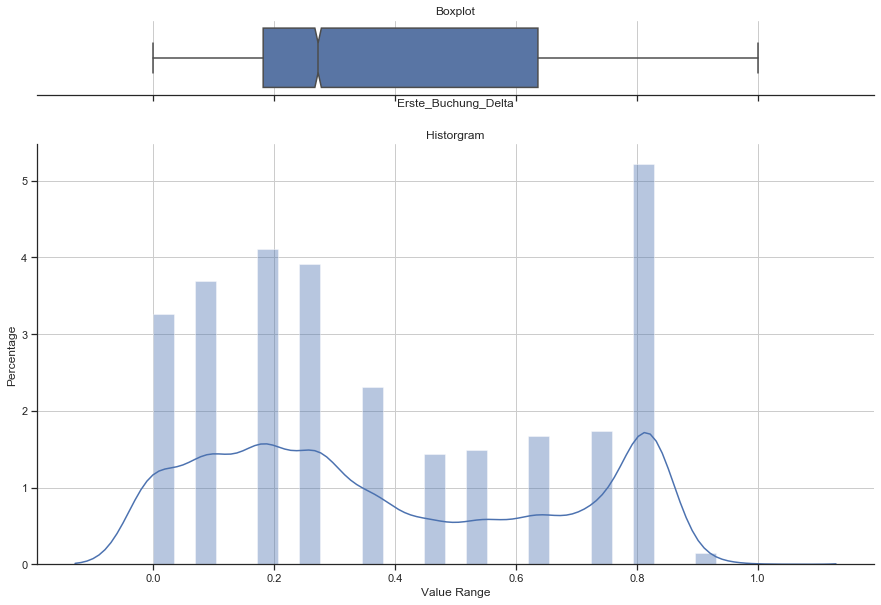

Target_Res_flg == True


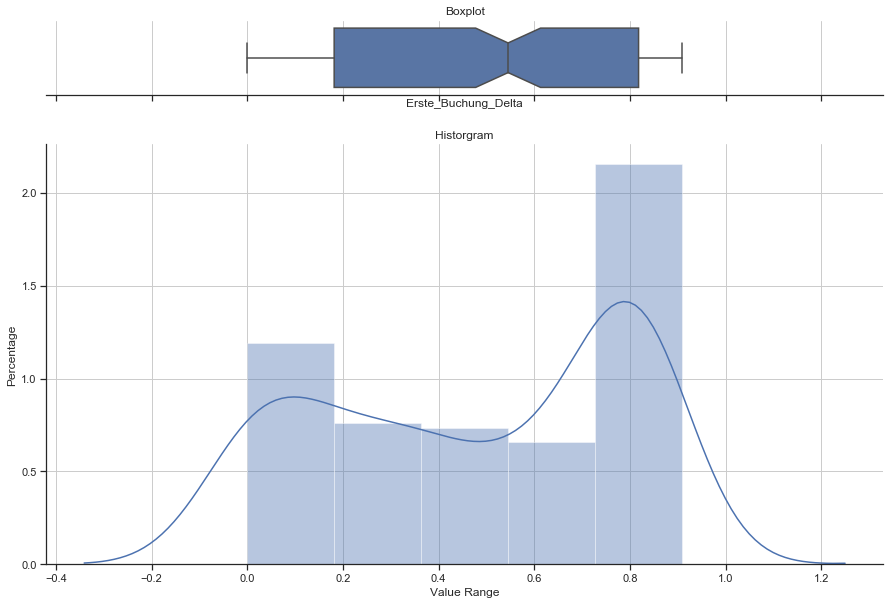

Target_Res_flg == False


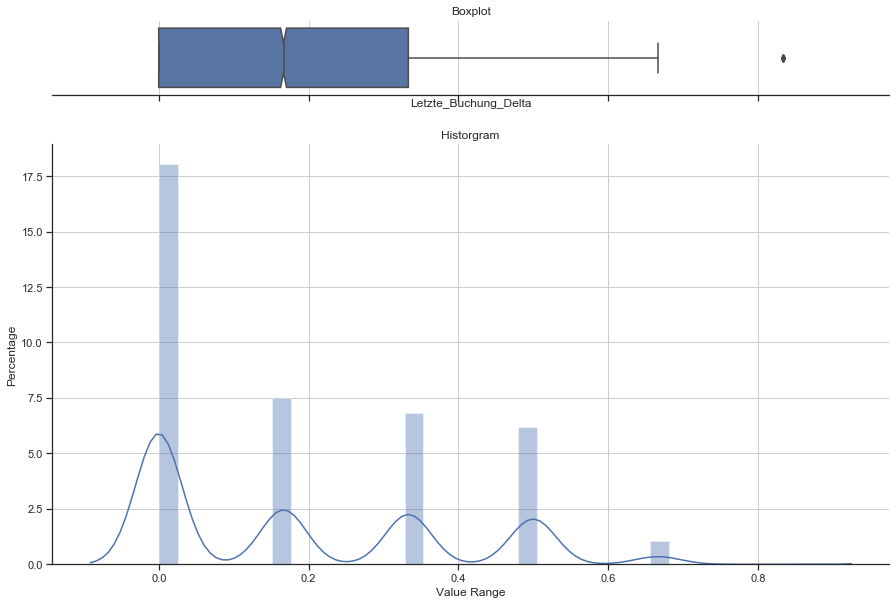

Target_Res_flg == True


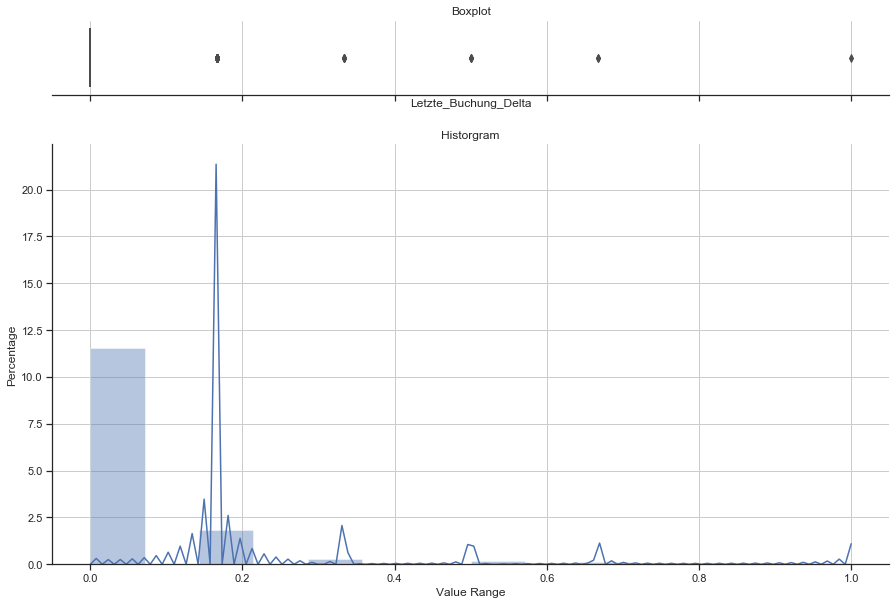

Target_Res_flg == False


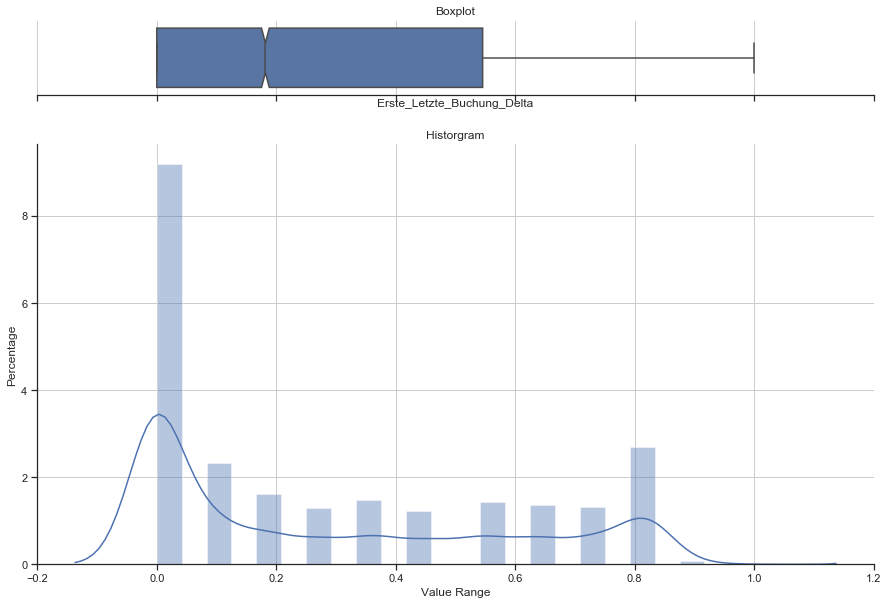

Target_Res_flg == True


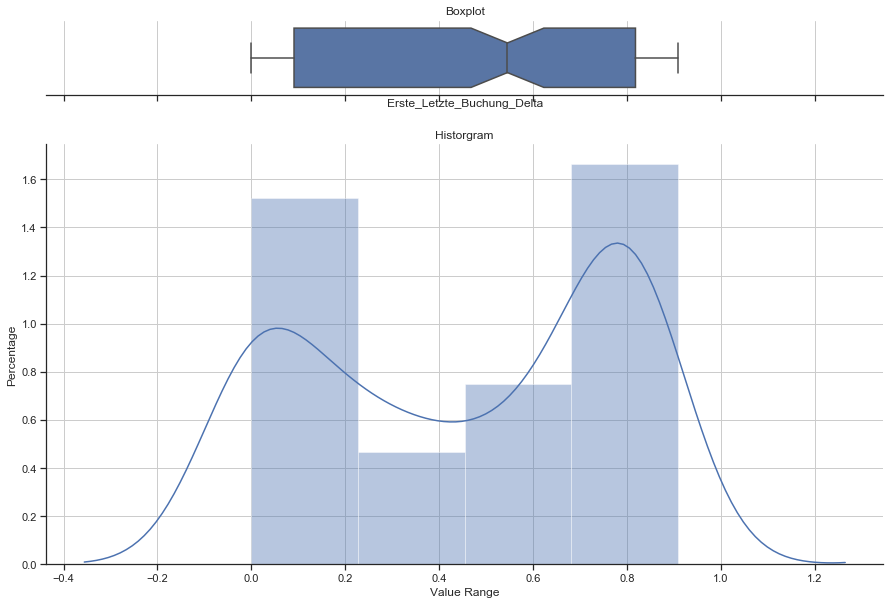

In [372]:
temp_df = training_all
print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Buchung_Delta"])

print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Letzte_Buchung_Delta"])


print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Letzte_Buchung_Delta"])

## Scale Data

<div class="alert alert-block alert-info">
<b>Remark:</b> Scaling has to take place after all filtrations have taken place!
</div>

In [367]:
def scaling_bd(dataset,col_bookings=[], col_dates=[]):
    """
    Booking columns are heavily right-skewed:
     1. log-transform all columns => achieving approx. gaussian distribution
     2. Standardise log-transformed values into interval [0,1]
     
    Return transformed dataframe
    """
    # Scaling: booking
    for x in col_bookings:
        logtransformed = np.log(dataset.loc[:,x]+1) # bookings are heavily right-skewed. log-transform to get approx. gaussian distribution
        min_ = np.min(logtransformed)
        max_ = np.max(logtransformed)
        dataset[x] = (logtransformed-min_)/(max_-min_) # standardise into floats in [0,1]
    
    for x in col_dates:
        transformed = dataset.loc[:,x]
        min_ = np.min(transformed)
        max_ = np.max(transformed)
        dataset[x] = (transformed-min_)/ (max_-min_)  
        
    
    return dataset

In [368]:
scaled_training_all = scaling_bd(training_all,col_bookings=feature_colnames_bd, col_dates=feature_colnames_dates)
scaled_scoring_all  = scaling_bd(scoring_all, col_bookings=feature_colnames_bd, col_dates=feature_colnames_dates)

In [380]:
# Summary
scaled_training_all.head(5)

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,...,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,Netto_Sum_Res_RY_2_KW_37,Netto_Sum_Res_RY_2_KW_39,Netto_Sum_Res_RY_2_KW_41,Netto_Sum_Res_RY_2_KW_43,Netto_Sum_Res_RY_2_KW_45,Netto_Sum_Res_RY_2_KW_47,Netto_Sum_Res_RY_2_KW_49,Netto_Sum_Res_RY_2_KW_5,Netto_Sum_Res_RY_2_KW_51,Netto_Sum_Res_RY_2_KW_7,Netto_Sum_Res_RY_2_KW_9,Netto_Sum_Res_RY_3_KW_1,Netto_Sum_Res_RY_3_KW_11,Netto_Sum_Res_RY_3_KW_13,Netto_Sum_Res_RY_3_KW_15,Netto_Sum_Res_RY_3_KW_17,Netto_Sum_Res_RY_3_KW_19,Netto_Sum_Res_RY_3_KW_21,Netto_Sum_Res_RY_3_

In [385]:
#print(list(training_all.columns))


Before:


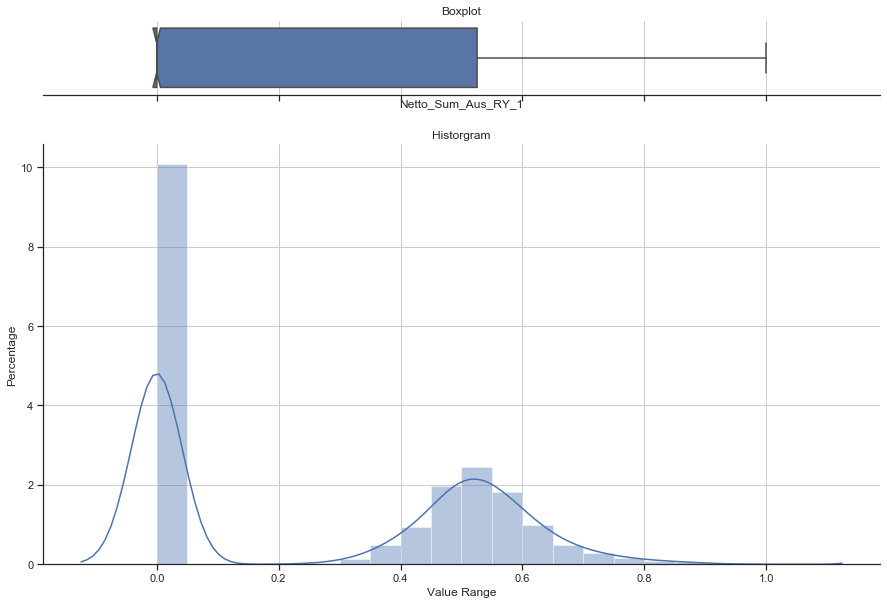

After:


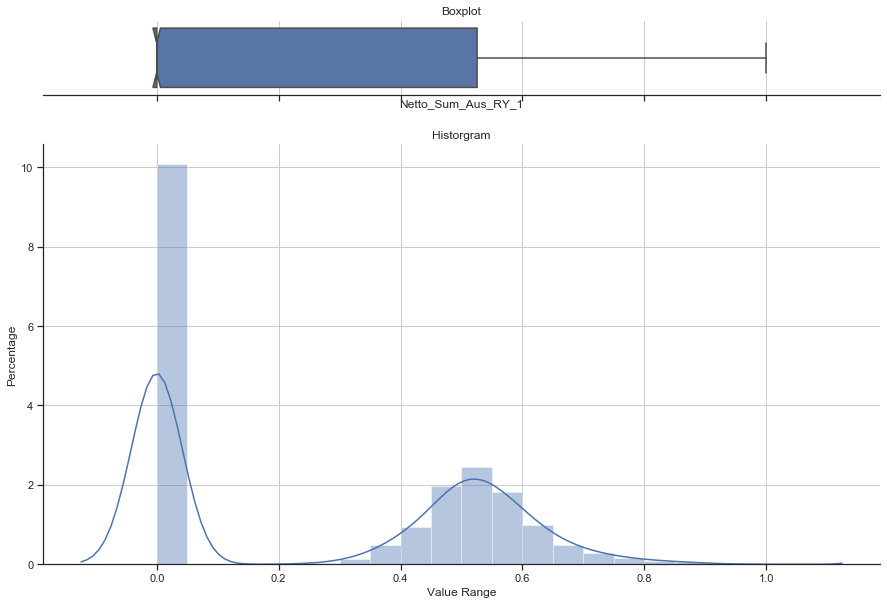

Before:


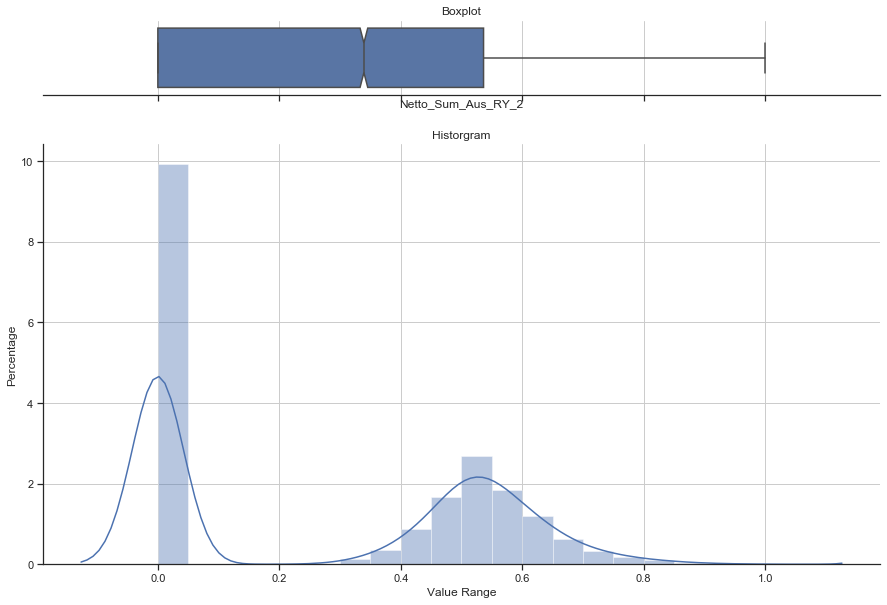

After:


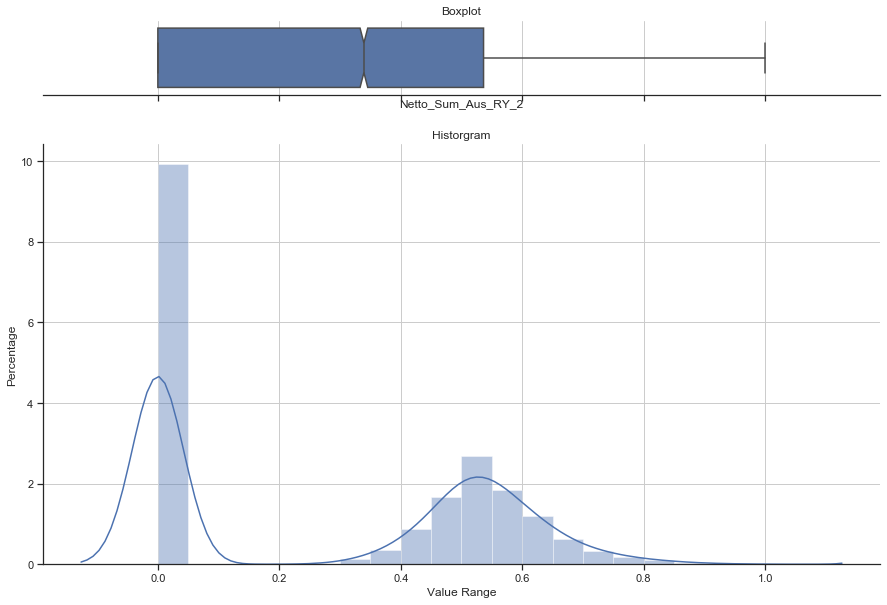

Before:


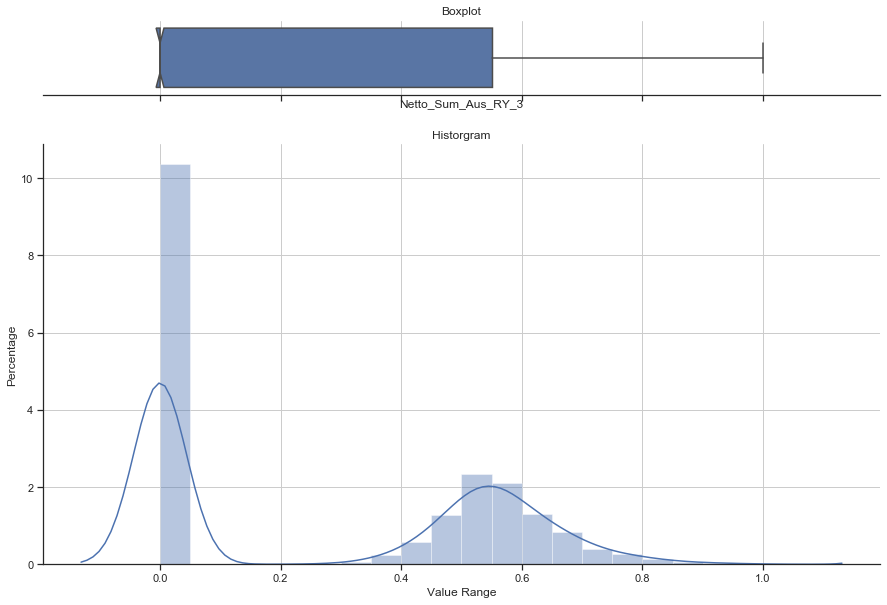

After:


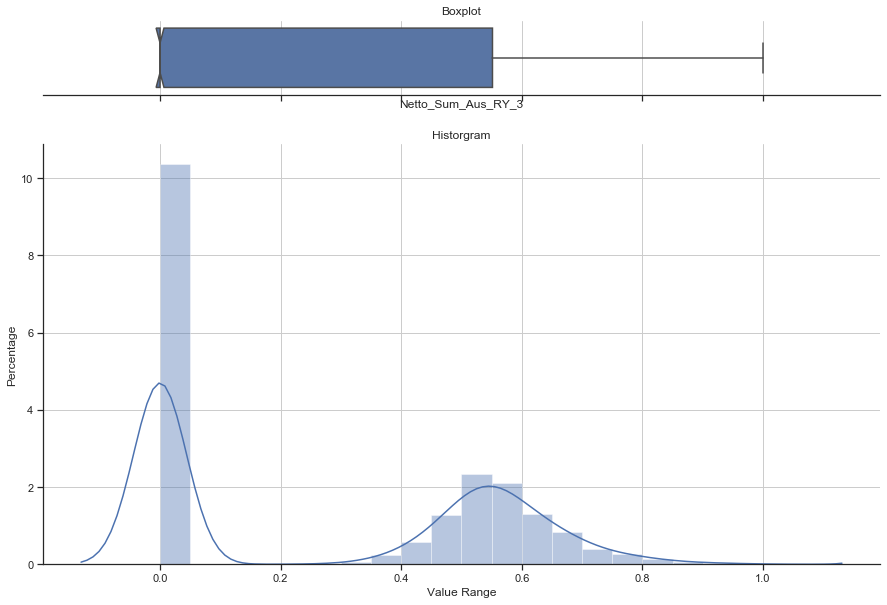

In [371]:
print("Before:")
boxplot_histogram(       training_all.loc[:,"Netto_Sum_Aus_RY_1"],bins=20)
print("After:")
boxplot_histogram(scaled_training_all.loc[:,"Netto_Sum_Aus_RY_1"],bins=20)
print("Before:")
boxplot_histogram(       training_all.loc[:,"Netto_Sum_Aus_RY_2"],bins=20)
print("After:")
boxplot_histogram(scaled_training_all.loc[:,"Netto_Sum_Aus_RY_2"],bins=20)
print("Before:")
boxplot_histogram(       training_all.loc[:,"Netto_Sum_Aus_RY_3"],bins=20)
print("After:")
boxplot_histogram(scaled_training_all.loc[:,"Netto_Sum_Aus_RY_3"],bins=20)

## Save Copy for R-Studio

In [378]:
scaled_training_all.to_csv("C:\\Users\\stc\\data\\blahblah.csv")

## CRM data


In [ ]:
%%time
ct_raw = load_bin("crm_data_vkprog.feather").rename(
    mapper=lambda name: cap_words(name, sep="_"), axis="columns"
)
ct = ct_raw.pipe(clean_up_categoricals)

In [ ]:
desc_col(ct)

In [ ]:
level1 = pd.Series(ct.Kanal).isin(["E-Mail", "Telefon"])
level2 = pd.Series(ct.Kanal).isin(["Besprechung", "Besuch"])

ct["level1"] = level1.map(lambda x: int(x))
ct["level2"] = level2.map(lambda x: int(x))

In [ ]:
ct.groupby("Kanal").count()

In [ ]:
ct[(ct["level1"] == 1) | (ct["level2"] == 1)].head(5)

In [ ]:
ct_flat = ct[(ct["level1"] > 0) | (ct["level2"] > 0)].pivot_table(
    #index=["Endkunde_NR", "Jahr"],
    index=["Endkunde_NR"],
    #columns="KW_2",
    columns = ["Year","KW_2"],
    values=["level1","level2"] ,
    aggfunc="max",
    fill_value=0, # There's a difference between 0 and NaN. Consider 0 only when the customer has had a real booking or reservation prior.
)

In [ ]:
ct_flat.head(3)

In [ ]:
desc_col(ct_flat)

In [ ]:
pd.Series(ct_flat.index)

In [ ]:
ct_flattened = pd.DataFrame(ct_flat.to_records(index=False))
ct_flattened["Endkunde_NR"] = pd.Series(ct_flat.index)

In [ ]:
#%% flatten booking dataset
ct_flattened.head(5)

In [ ]:
#%% Clean up column names
raw_col_names_ct = list(ct_flattened.columns)[0:-1]
splitted_col_names = [x.lstrip("(").rstrip(")").split(", ") for x in raw_col_names_ct]
col_names_flattened = [(content_name.replace("'",""), int(x)*100+int(y)) for [content_name,x,y] in splitted_col_names] + list(ct_flattened.columns)[ct_flattened.shape[1]-1:ct_flattened.shape[1]]

#%% Set cleaned up column names
ct_flattened.columns = col_names_flattened

In [ ]:
ct_flattened.head(5)

In [ ]:
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##

# Import Data: tds == TDS == gv_FILE_OUT_TDS

In [ ]:
TDS = pd.read_csv("C:/Users/stc/Documents/notebooks/Verkaufsprognose Modeling/TDS.csv", low_memory=False, sep=';')

In [ ]:
display(TDS.describe())
print(TDS.shape)

In [ ]:
TDS.head(5)
#DS.info()

## Intermezzo: Whiteboard problems

In [ ]:
# Which customers have the most rows in the dataframe?
(TDS.groupby(["ENDKUNDE_NR"]).size().to_frame('COUNT')
                             .reset_index()
                             .sort_values(['COUNT', 'ENDKUNDE_NR'],ascending=[False,False])
                             .head(10))


In [ ]:
TDS.loc[TDS.ENDKUNDE_NR == 606399, # row selection
        :
        
       ]         # column selection

In [ ]:
TDS.loc[TDS.ENDKUNDE_NR == 606399, # row selection
        ["ENDKUNDE_NR", "AJ",
        "AJ_27","VJ_27","VVJ_27","VVVJ_27",
         "AJ_31","VJ_31","VVJ_31","VVVJ_31",
         "AJ_35","VJ_35","VVJ_35","VVVJ_35"
        ]
        
       ]         # column selection

In [ ]:
TDS.loc[TDS.ENDKUNDE_NR == 608966, # row selection
        ["ENDKUNDE_NR", "AJ",
         "AJ_03","VJ_03", "VVJ_03","VVVJ_03",  "AJ_51","VJ_51","VVJ_51","VVVJ_51"]
        
       ]         # column selection

In [ ]:
TDS.loc[TDS.ENDKUNDE_NR == 608966, # row selection
        ["ENDKUNDE_NR", "AJ",
         "AJ_03","VJ_03", "VVJ_03","VVVJ_03",  "AJ_51","VJ_51","VVJ_51","VVVJ_51"]
        
       ]         # column selection

# Data Preparation

## Data Selection

Originale erhalten für Vorhersage

In [ ]:
gv_AJAW_KW = 29 # aktuelle Kalenderwoche, basierend auf gv_AJAW = Datum an dem das Script lief, 15.07.2019

In [ ]:
feature_columns   = [] # Features/Merkmale
predictor_columns = [] # Predictores/Targets
leftover_columns  = [] # Leftover
for col_name in TDS.keys():
    if (col_name.startswith("VJ")  | # Umsatz Vorjahr
        col_name.startswith("VVJ") |
        col_name.startswith("VVVJ")|
        col_name.startswith("B")   ):
        feature_columns.append(col_name)
    elif (col_name.startswith("AJ_") and len(col_name) < 6)  :
        predictor_columns.append(col_name)
    else:
        leftover_columns.append(col_name)

    

Exclude ``VJ_KONTAKT_L1_KW29``:

In [ ]:
feature_columns.remove(f"VJ_KONTAKT_L1_KW{gv_AJAW_KW}") # it's removed in the R-Markdown script
#feature_columns.remove("VJNet")
feature_columns.sort()

## Data Check

In [ ]:
df_describe = TDS.loc[:,feature_columns+["AJ_29"]]
df_describe["target"] = TDS["AJ_29"].map(lambda x: int(bool(abs(x))))

In [ ]:
def desc_tool(df_x):
    pd.options.display.max_columns = None
    display(df_x.head(5))
    display(df_x.describe())
    #print("\ndf_x.info():",df_x.info())
    print("\nDataset Shape:",df_x.shape)

In [ ]:
desc_tool(df_describe)

In [ ]:
%%time
#pairplot
sns.pairplot(df_describe.loc[:,["VJ_NETKAT_01","VJNet","target"]], hue="target", height=3)
plt.savefig("pairplot.png")
#plt.show()

In [ ]:
sns.FacetGrid(df_describe, hue="target", height=4).map(sns.distplot,"VJNet").add_legend()
plt.show()
fig, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="target",y="VJNet", data=df_describe, ax=ax)
plt.show()

In [ ]:
import matplotlib.mlab as mlab
from   matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np

x = TDS.loc[TDS.AJ_29>0 ,"AJ_29"]
y = np.log(TDS.loc[TDS.AJ_29>0,"AJ_29"]+1)
n_bins=50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(15,5))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[0].grid(True)
axs[1].hist(y, bins=n_bins)
axs[1].grid(True)

In [ ]:
#TDS.loc[TDS.AJ_29>0,"AJ_29"]

## Dataset-Mapping to Zero/One

Prediktor festlegen: Aktuelle Woche basierend auf ``gv_AJAW_KW = 29``:

In [ ]:
df_ft_binary = TDS.fillna(0).loc[:,feature_columns+["AJ_29"]]
for col in df_ft_binary.columns:
    df_ft_binary[col] = df_ft_binary[col].map(lambda x: int(bool(x)))

=> ``df_ft_binary``: Dataframe with features and target, all entries as binaries.

### Quick check

In [ ]:
print("All occuring values in df_ft_binary are binary:",all(df_ft_binary.isin([0,1])))

# Modelling

## Split: Training & Test

In [ ]:
df_features = df_ft_binary.loc[:,feature_columns].to_numpy()
df_target   = df_ft_binary.loc[:, "AJ_29"].to_numpy()

In [ ]:
#df_features    = TDS.fillna(0).loc[:,feature_columns].to_numpy()
#df_target      = TDS.fillna(0).loc[:,"AJ_29"].to_numpy()

print("Data type:")
print("df_features:", type(df_features))
print("df_target:", type(df_target))
print("\nShape:")
print("df_features:", df_features.shape)
print("df_target:", df_target.shape)
print("\nColumn Names:")
print("Features:\n", feature_columns)
print("Target:", "AJ_29") # <= NEEDS TO BE ADJUSTED!

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    #df_features, df_target, train_size=0.80, random_state=42)
    df_features, df_target, train_size=0.75, random_state=42)


In [ ]:
print("Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


In [ ]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(stats.describe(y_test))

<div class="alert alert-block alert-info">
<b>Remark:</b> Dataset is massively imbalanced! Only roughly 3% of the Training dataset is 1. This means if I predict all customers to have a Zero, I will be in 97% of the cases correct (on the training set). In order to achieve more reliable scoring models, the training dataset (X_train, y_train) has to be balanced.
</div>

### Balance Training Dataset

#### Synthetic Minority Over-sampling Technique (SMOTE)

In [ ]:
# pip install imblearn
#from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [ ]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

pd.Series(y_train_balanced).value_counts()

## Model Training

###  Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

C is the Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

1. logreg:   $C = 1$
2. logreg01: $C = 0.1$
3. logreg00001: $C = 0.0001$
4. logreg100: $C = 100$

In [ ]:
def create_logreg(C=[1]):
    """Create different models for varying C parameter. Put everything into a dictionary."""
    logreg_dict = {}
    for x in C:
        logreg_dict[x] = LogisticRegression(n_jobs=-1,
                                    solver="sag",
                                    C=x, # to be adjusted
                                    max_iter=1000000
                                   ).fit(X_train_balanced, y_train_balanced)
    return logreg_dict

In [ ]:
logreg_dict = create_logreg([1,0.0001,0.01,0.1,100])

In [ ]:
logreg_dict

In [ ]:
logreg_scores = pd.DataFrame([
    [x, logreg_dict[x].score(X_train_balanced, y_train_balanced),
        logreg_dict[x].score(X_test, y_test)] for x in logreg_dict.keys()], columns=["LogReg C", "Training set score","Test Set score"])

In [ ]:
logreg_scores

In [ ]:
%%time
logreg = LogisticRegression(n_jobs=-1,
                            max_iter=100000,
                            solver="sag",
                            C=1000 # to be adjusted
                           ).fit(X_train_balanced, y_train_balanced)

#logreg = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

In [ ]:
%%time
# %% Train data: LogReg with C = 0.01
logreg001 = LogisticRegression(n_jobs=-1,
                               max_iter=100000,
                               solver="sag", # L2 regularisation
                               C=0.01 # adjustable
                              ).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.3f}".format(logreg001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

In [ ]:
%%time
logreg00001 = LogisticRegression(n_jobs=-1,
                                 max_iter=100000,
                               solver="sag",
                               C=0.0001 # adjustable
                              ).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.3f}".format(logreg00001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg00001.score(X_test, y_test)))

In [ ]:
%%time
logreg100 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=100 #adjustable
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg100.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg100.score(X_test, y_test)))

#### Plot coefficients

In [ ]:
temp = np.asarray([x for [x] in logreg100.coef_.T]).argsort()
ranks= np.empty_like(temp)
ranks[temp] = np.arange(len(temp))

sorted_logreg100       = [0 for x in range(len(temp))]
sorted_logreg          = [0 for x in range(len(temp))]
sorted_logreg001       = [0 for x in range(len(temp))]
sorted_logreg00001     = [0 for x in range(len(temp))]
sorted_feature_columns = [0 for x in range(len(temp))]
for i in range(len(temp)):
    sorted_logreg100[ranks[i]]       = logreg100.coef_.T[i]
    sorted_logreg[ranks[i]]          = logreg.coef_.T[i]
    sorted_logreg001[ranks[i]]       = logreg001.coef_.T[i]
    sorted_logreg00001[ranks[i]]     = logreg00001.coef_.T[i]
    sorted_feature_columns[ranks[i]] = feature_columns[i]
    
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(sorted_logreg100 , '^', label="C=100")
plt.plot(sorted_logreg,    'o', label="C=1")
plt.plot(sorted_logreg001, 'v', label="C=0.001")
plt.plot(sorted_logreg00001, 's', label="C=0.0001")
plt.xticks(range(len(feature_columns)), sorted_feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg100.coef_.T), max(logreg100.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

In [ ]:
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg.coef_.T,    'o', label="C=1")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.plot(sorted_logreg00001, 's', label="C=0.0001")
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg.coef_.T), max(logreg.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

### Lasso

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
%%time
lasso = Lasso().fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

In [ ]:
%%time
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

In [ ]:
%%time

lasso00000001 = Lasso(alpha=0.0000001, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso00000001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso00000001.score(X_test,      y_test)))
print("Number of features used:", np.sum(lasso00000001.coef_ != 0))

In [ ]:
%%time
lasso000001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso000001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso000001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso000001.coef_ != 0))

=> ALL SUPERMASSIVE CRAP

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time

forest = RandomForestClassifier(n_estimators=10000,
                                max_depth=15,
                                random_state=42,
                                n_jobs=-1)
forest.fit(X_train_balanced, y_train_balanced)

# %% Validate Accuracy
print("Accuracy on training set: {:.3f}".format(forest.score(X_train_balanced,y_train_balanced)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test,     y_test)))

In [ ]:
# %% Plot: Feature importance
def plot_feature_importances(model,feature_columns,figsize=(20,100)):
    from operator import itemgetter
    dict_feature_importance = sorted(dict(zip(feature_columns,model.feature_importances_)).items(), key=itemgetter(1))
    n_features              = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.barh(np.arange(n_features),
             [y for (x,y) in dict_feature_importance],
             align='center')
    plt.yticks(np.arange(n_features), [x for (x,y) in dict_feature_importance])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

In [ ]:
plot_feature_importances(forest,feature_columns)
#plot_feature_importances(forest_selected,feature_columns_selected)

# Automated Feature selection: SelectPercentile

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif # ANOVA F-value
from sklearn.feature_selection import mutual_info_classif

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

1. ``f_classif `` ANOVA assumes normal distribution. (nope)
2. ``mutual_info_classif`` Mutual information for a discrete target.
3. ``chi2`` Chis-squared starts of non-negative features for classification tasks.
4. ``f_regression`` F-value between label/feature for regression tasks.
5. ``mutual_info_regression`` Mutual information for a continuous target.
6. ``SelectKBest`` Select features based on the k highest scores
7. ``SelectFpr`` Select features based on a FPR test.
8. ``SelectFdr`` Select features based on an estimated false discovery rate
9. ``SelectFwe`` Select features based on family-wise error rate.
10. ``GenericUnivariateSelect`` Univariate feature selector with configurable mode.

In [ ]:
%%time
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(score_func=mutual_info_classif,
                          percentile=50)
select.fit(X_train_balanced, y_train_balanced)
# transform training set
X_train_selected = select.transform(X_train_balanced) # not needed. we have the mask (boolean array).

print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

In [ ]:
mask = select.get_support()
#print(mask)
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())
plt.show()

In [ ]:
from itertools import compress
feature_columns_selected = list(compress(feature_columns,mask))

print("Selected features:\n",feature_columns_selected)
#print(feature_columns)

In [ ]:
print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))
print("X_train_balanced[:,mask].shape: {}".format(X_train_balanced[:,mask].shape))

In [ ]:
%%time
logreg_selected = LogisticRegression(n_jobs=-1,
                            solver="sag",
                            C=1 # to be adjusted
                           ).fit(X_train_balanced[:,mask], # We select only those we need
                                 y_train_balanced)

forest_selected = RandomForestClassifier(n_estimators=10000,
                                max_depth=35,
                                random_state=42,
                                n_jobs=-1)

forest_selected.fit(X_train_balanced[:,mask],
           y_train_balanced)

In [ ]:
# %% Validate Accuracy
print("Random Forest, newly selected features:")
print("Accuracy on training set: {:.3f}".format(forest_selected.score(X_train_balanced[:,mask],
                                                             y_train_balanced)))

print("Accuracy on test set: {:.3f}".format(forest_selected.score(X_test[:,mask],
                                                         y_test)))

print("\nLogististic Regression C=1, newly selected features:")
print("Training set score: {:.3f}".format(logreg_selected.score(X_train_balanced[:,mask], # Obviously only applicable to the subselect
                                                                y_train_balanced))) 
print("Test set score: {:.3f}".format(logreg_selected.score(X_test[:,mask], # Obviously only applicable to the subselect
                                                            y_test)))

print("\nLogististic Regression C=1, all features:")
print("Training set score: {:.3f}".format(logreg.score(X_train_balanced,y_train_balanced))) 
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

print("\nRandom Forest, all features:")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train_balanced,
                                                             y_train_balanced)))

print("Accuracy on test set: {:.3f}".format(forest.score(X_test,
                                                         y_test)))
print("\n")

In [ ]:
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg_selected.coef_.T,    'o', label="C=1")
plt.xticks(range(len(feature_columns_selected)), feature_columns_selected, rotation=90)
plt.hlines(0, 0, len(feature_columns_selected))
plt.ylim(min(logreg.coef_.T), max(logreg_selected.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

In [ ]:
plot_feature_importances(forest_selected,
                         feature_columns_selected,
                         figsize=(20,50))

# Model Validatian 

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
%%time
#logreg = LogisticRegression(C=1, solver='lbfgs').fit(X_train_binary, y_train_binary)
pred_logreg          = logreg.predict(X_test)
pred_logreg_selected = logreg_selected.predict(X_test[:,mask])
pred_forest          = forest.predict(X_test)
pred_forest_selected = forest_selected.predict(X_test[:,mask])

In [ ]:
%%time
confusion_logreg             = confusion_matrix(y_test, pred_logreg)
df_confusion_logreg          = pd.DataFrame(confusion_logreg, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_logreg_selected    = confusion_matrix(y_test, pred_logreg_selected)
df_confusion_logreg_selected = pd.DataFrame(confusion_logreg_selected, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_forest             = confusion_matrix(y_test, pred_forest)
df_confusion_forest          = pd.DataFrame(confusion_forest, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_forest_selected    = confusion_matrix(y_test, pred_forest_selected)
df_confusion_forest_selected = pd.DataFrame(confusion_forest_selected, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

print("Test set balance:")
print(sorted(Counter(y_test).items()),"\n")

print("Confusion Matrices:")

print("Logistic Regression C=1:")
display(df_confusion_logreg)

print("Logistic Regression C=1, newly selected features:")
display(df_confusion_logreg_selected)

print("Random Forest:")
display(df_confusion_forest)

print("Random Forest, newly selected features:")
display(df_confusion_forest_selected)

In [ ]:
#import mglearn
#mglearn.plots.plot_binary_confusion_matrix()

1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


In [ ]:
from sklearn.metrics import classification_report
print("Logistic Regression C=1:")
print(classification_report(y_test,
                            pred_logreg,
                            target_names=["not booking = 0", "booking = 1"]))
print("\n")
print("Logistic Regression C=1, newly selected features:")
print(classification_report(y_test,
                            pred_logreg_selected,
                            target_names=["not booking = 0", "booking = 1"]))
print("\n")
print("Random Forest:")
print(classification_report(y_test,
                            pred_forest,
                            target_names=["not booking = 0", "booking = 1"]))

print("\n")
print("Random Forest, new selected:")
print(classification_report(y_test,
                            pred_forest_selected,
                            target_names=["not booking = 0", "booking = 1"]))

Lower the Threshold:

In [ ]:
def threshold_test(number):
    y_pred_lower_threshold = logreg.decision_function(X_test) > number
    print(classification_report(y_test, y_pred_lower_threshold))

In [ ]:
threshold_test(0.1)

In [ ]:
def prob_threshold(number):
    y_pred_prob_threshold = np.asarray([y for [x,y] in logreg100.predict_proba(X_test)]) > number
    print(classification_report(y_test, y_pred_prob_threshold))

In [ ]:
for x in np.around(np.arange(0,1,0.1),decimals=1):
    print("Threshold =",x,":")
    print(prob_threshold(x),"\n")


In [ ]:
boxplot_histogram(logreg.decision_function(X_test), 
                  #np.random.normal(loc=10, scale=5, size=10000), # gaussian distributed array, mean = 10, standard deviation = 5, length = 100000
                  bins=200,
                  figsize=(20,10))

In [ ]:
threshold_test(-100)

## Precision-Recall curve

In [ ]:
%%time
from sklearn.metrics import precision_recall_curve

def prec_rec_curve(X_test,y_test):
    global precision_logreg, recall_logreg, thresholds_logreg, precision_logreg_selected, recall_logreg_selected, thresholds_logreg_selected, precision_forest, recall_forest, thresholds_forest, precision_forest_selected, recall_forest_selected, thresholds_forest_selected
    
    precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(
        y_test, 
        logreg.decision_function(X_test))

    #
    precision_logreg_selected, recall_logreg_selected, thresholds_logreg_selected = precision_recall_curve(
        y_test, 
        logreg_selected.decision_function(X_test[:,mask]))

    # RandomForestClassifier has predict_proba, but not decision_function
    precision_forest, recall_forest, thresholds_forest = precision_recall_curve(
        y_test,
        forest.predict_proba(X_test)[:, 1])

    precision_forest_selected, recall_forest_selected, thresholds_forest_selected = precision_recall_curve(
        y_test,
        forest_selected.predict_proba(X_test[:,mask])[:, 1])


In [ ]:
%%time
#prec_rec_curve(X_test,y_test)
prec_rec_curve(X_train,y_train)

In [ ]:
plt.figure(figsize=(20,15))
plt.grid()

close_zero = np.argmin(np.abs(thresholds_logreg))
plt.plot(precision_logreg[close_zero],
         recall_logreg[close_zero],
         'o',
         markersize=10,
         label="threshold zero LogReg",
         fillstyle="none",
         c='k',
         mew=2)

plt.plot(precision_forest, recall_forest, label="Random Forest")
plt.plot(precision_forest_selected, recall_forest_selected, label="Random Forest, newly selected features")
plt.plot(precision_logreg, recall_logreg, label="Logistic Regression, C=1")
plt.plot(precision_logreg_selected, recall_logreg_selected, label="Logistic Regression, C=1, newly selected features")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

plt.show()

<div class="alert alert-block alert-info">
<b>Remark:</b> This plot looks horrible. HORRIBLE!!!
</div>

In [ ]:
%%time
from sklearn.metrics import average_precision_score # Area under the Recall/Precision-curves

avg_precision_forest = average_precision_score(y_test,
                                               forest.predict_proba(X_test)[:, 1])

avg_precision_forest_selected = average_precision_score(y_test,
                                               forest_selected.predict_proba(X_test[:,mask])[:, 1])

avg_precision_logreg = average_precision_score(y_test,
                                               logreg.decision_function(X_test))

avg_precision_logreg_selected = average_precision_score(y_test,
                                               logreg_selected.decision_function(X_test[:,mask]))

print("Average Precision of Random Forest: {:.3f}".format(avg_precision_forest))
print("Average Precision of Random Forest, newly selected features: {:.3f}".format(avg_precision_forest_selected))
print("Average Precision of Logistic Regression C=1: {:.3f}".format(avg_precision_logreg))
print("Average Precision of Logistic Regression C=1, newly selected features: {:.3f}".format(avg_precision_logreg_selected))

## Receiver operating characteristics (ROC) and AUC

1. $FPR = \frac{FP}{FP + TN}$ 
2. $TPR = Recall$

In [ ]:
%%time
from sklearn.metrics import roc_curve

fpr_logreg,          tpr_logreg,          thresholds_logreg      = roc_curve(y_test, logreg.decision_function(X_test))
fpr_logreg00001,     tpr_logreg00001,     thresholds_logreg00001 = roc_curve(y_test, logreg00001.decision_function(X_test))
fpr_logreg001,       tpr_logreg001,       thresholds_logreg001       = roc_curve(y_test, logreg001.decision_function(X_test))
fpr_logreg100,       tpr_logreg100,       thresholds_logreg100       = roc_curve(y_test, logreg100.decision_function(X_test))
fpr_logreg_selected, tpr_logreg_selected, thresholds_logreg_selected = roc_curve(y_test, logreg_selected.decision_function(X_test[:,mask]))
fpr_forest,          tpr_forest,          thresholds_forest      = roc_curve(y_test, forest.predict_proba(X_test)[:, 1])
fpr_forest_selected, tpr_forest_selected, thresholds_forest_selected = roc_curve(y_test, forest_selected.predict_proba(X_test[:,mask])[:, 1])

In [ ]:
%%time
plt.figure(figsize=(20,15))
plt.grid()

plt.plot(fpr_logreg,fpr_logreg, linestyle='dotted', label="base line")

plt.plot(fpr_logreg,      tpr_logreg,      label="LogReg C=1")
#plt.plot(fpr_logreg00001, tpr_logreg00001, label="LogReg C=0.0001")  # bad!
plt.plot(fpr_logreg001,   tpr_logreg001,   label="LogReg C=0.01")
#plt.plot(fpr_logreg100,   tpr_logreg100,   label="LogReg C=100.0")
plt.plot(fpr_logreg_selected, tpr_logreg_selected,  label="LogReg C=1, selected")
plt.plot(fpr_forest,      tpr_forest,      label="ROC Curve Forest")
plt.plot(fpr_forest_selected,tpr_forest_selected,      label="ROC Curve Forest, selected")


plt.xlabel("False-Postive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR) aka. Recall")

# find threshold closest to zero
close_zero_index = np.argmin(np.abs(thresholds_logreg))
plt.plot(fpr_logreg[close_zero_index], tpr_logreg[close_zero_index],
         'o',
         markersize=10,
         label="threshold close zero, LogReg C=1",
         fillstyle="none",
         c='k',
         mew=2)

close_default_index_forest = np.argmin(np.abs(thresholds_forest - 0.5))
plt.plot(fpr_forest[close_default_index_forest], tpr_forest[close_default_index_forest],
         '^',
         markersize=10,
         label="threshold 0.5 Random Forest",
         fillstyle="none",
         c='k',
         mew=2)

plt.legend(loc=4)
plt.show()

In [ ]:
%%time
from sklearn.metrics import roc_auc_score
forest_auc = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
forest_selected_auc = roc_auc_score(y_test, forest_selected.predict_proba(X_test[:,mask])[:, 1])

logreg001_auc       = roc_auc_score(y_test, logreg001.decision_function(X_test))
logreg_auc          = roc_auc_score(y_test, logreg.decision_function(X_test))
logreg00001_auc     = roc_auc_score(y_test, logreg00001.decision_function(X_test))
logreg100_auc       = roc_auc_score(y_test, logreg100.decision_function(X_test))
logreg_selected_auc = roc_auc_score(y_test, logreg_selected.decision_function(X_test[:,mask]))

In [ ]:
print("AUC for Random Forest:           {:.3f}".format(forest_auc))
print("AUC for Random Forest, selected: {:.3f}".format(forest_selected_auc))
print("AUC for LogReg C=0.001:          {:.3f}".format(logreg001_auc))
print("AUC for LogReg C=0.0001:         {:.3f}".format(logreg00001_auc))
print("AUC for LogReg C=1, selected:    {:.3f}".format(logreg_selected_auc))
print("AUC for LogReg C=1:              {:.3f}".format(logreg_auc))
print("AUC for LogReg C=100:            {:.3f}".format(logreg100_auc))

# Cross-Validation in Scikit-Learn

1. https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch05.html#model-evaluation-and-improvement
3. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg,
                         np.concatenate([X_train_balanced,X_test]),
                         np.concatenate([y_train_balanced,y_test]), 
                         cv=5)
print("Cross-validation scores: {}".format(scores))

In [ ]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

In [ ]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg,
                     np.concatenate([X_train_balanced,X_test]),
                     np.concatenate([y_train_balanced,y_test]),
                     cv=5,
                     return_train_score=True)
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())